<h1 style="text-align: center;" >Loan Approval Predictor</h1>                                          

<p align="center">
<img width="650" src="https://media2.giphy.com/media/NyniJ2Nf2ZzlE8GYsl/giphy.gif?cid=ecf05e47i7yffb7wyzmxxeajy7opvap90i6chvh6x07jnpzq&rid=giphy.gif&ct=g" alt="Assignment 2" title="" />
    
</p>
    

# Table of Content: <a class="car" id="table-of-content"></a>
* [1. Problem Background and Motivation](#problem-background)<br>
* [2. Libraries ](#import-packages)<br>
 * [2.1 User Defined Functions](#udf)<br>    
* [3. Data Preparation](#data-prep)<br>
* [4. Machine Learning Model Implementation](#ml-model)<br>
* [5. Deployment of Model](#model-deployment)<br><br>

[Conclusion](#Conclusion)

# 1. Problem Background and Motivation <a class="car" id="problem-background"></a>

### Loan Approval Estimator for CHY Bank

>**What is the problem in Question?**<br>
>  Our goal is to predict loan approval for new applicants based on various parameters such as credit history, debt, prior default, employment type, and so on.<br>
Because lenders are prohibited by law from using a borrower's ascribed characteristics, such as age, gender, race, ethnicity, or religion, when making credit or loan decisions, I am removing certain characteristic parameters from evaluation <br><br>

>**Who will be our stakeholders?**<br>
> * **Banks**: Banks can conduct a preliminary test to narrow the pool of applicants, saving time and money so that they can focus their resources on genuine applicants. <br>

>**Why is it important?**<br>
> This allows stakeholders to conduct preliminary tests to narrow the applicant pool and conduct extensive research on qualified applicants.




# 2. Libraries Used <a class="car" id="import-packages"></a>
* [Go to Top](#table-of-content)

In [410]:
######################################
# Importing various python libraries
#  1. Pandas is a data analysis and manipulation library. We are using it to read the datasets
#  2. sklearn is machine learning library of python. we need it for running the prediction model.
#  3. Multiple visualization libraries are given below
######################################
import pandas as pd
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score,roc_curve,plot_roc_curve

pd.set_option('display.max_columns', None)

pd.options.display.float_format = '{:,.2f}'.format

## 2.1 User Defined Functions <a class="car" id="udf"></a>
* [Go to Top](#table-of-content)

In [411]:
#########################
#Additional user defined functions 
#########################
'''
In this Function we are using inbuilt libraries to create a datafraem with all relevant performance measures
'''
def class_perf_measures(model,y_test,probab_threshold):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    AUC_ROC =[]    

    # Start loop
    for i in probab_threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)

        # Append lists with metric values
        TP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,1])
        TN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,0])
        FP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,1])
        FN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,0])
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class,zero_division=0).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))
        AUC_ROC.append(metrics.roc_auc_score(y_test, y_test_pred_class))

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "Precision":precision,
                           "Recall":recall,
                           "f1":F1,
                           "AUC_ROC":AUC_ROC,
                           "Accuracy": Accuracy
                          })

    # Let's look at our dataframe
    return result

def data_stats(df,feature_list):
    '''
    This function we are calculating basic stats for all numerical columns. 
    To indicate outlier presence we are chcking if std/mean is greater than 1.5. Also if skewness of these columns
    are outside +-3 range
    '''
    temp =  df[feature_list].describe().round(2).T
    temp['median'] = df[feature_list].median().round(2)
    temp['outlier_presence'] = np.where((temp['std']/temp['mean']>2.5)| (df[feature_list].skew(axis = 0)>3) |(df[feature_list].skew(axis = 0)<-3),'True','False')
    return temp







# 3. Data Prep <a class="car" id="data-prep"></a>
* [3.1. Data Ingestion](#data-ingest)<br>
* [3.2. Remove Duplicates/Null values](#null-values)<br>
* [3.3. Feature Selection](#numfeature-selection)<br>
 * [3.3.1 Dealing with Outliers](#outlier-detection)<br>
 * [3.3.2 Check correlation](#correlations)<br>

* [3.4. Dealing with Categorical data](#categorical-data)<br>
 * [3.4.1 Reducing categorical data](#red-categorical-data)<br>
* [3.5. Multivariate Analysis](#mul-analysis)<br>
* [3.6. Feature Transformation and Finalization](#feature-transform)<br>
* [3.7. Splitting the data](#data-split)
* [3.8 Data Normalization](#normalization)




<br><br>
* [Go to Top](#table-of-content)

## 3.1 Data Ingestion <a class="car" id="data-ingest"></a>
* [Go to Data Prep](#data-prep)

In [412]:
df = pd.read_csv("loan_approval.csv")

# df.tail()

# df.dtypes

> **Initial Evaluation**<br>

> approved is our target.<br>

> Numerical Variables: gender, age ,debt,married, bank_customer, years_employed, prior_default, employed, credit_score, Income

> Categorical variables: employment type, ethnicity, citizen


## 3.2 Remove Duplicates/Null values <a class="car" id="null-values"></a>
* [Go to Data Prep](#data-prep)

In [413]:
######################################
# Removing duplicates
######################################
cnt =df.shape[0]
print("Number of records before removing duplicates: "+str(cnt))

df.drop_duplicates(inplace =True)

print("Number of records after removing duplicates: "+str(df.shape[0]))
print("Duplicate records in the dataset: "+str(cnt - df.shape[0]))

Number of records before removing duplicates: 690
Number of records after removing duplicates: 690
Duplicate records in the dataset: 0


**Note**: No duplicates. 

In [414]:
######################################
# Removing Null values for our model to work
######################################
#This indicated sum of null values from all columns
# df.isnull().sum()

>**Decision:**
> * No Null values


## 3.3 Numerical Feature Selection <a class="car" id="numfeature-selection"></a>
* [Go to Data Prep](#data-prep)

In [415]:
######################################
# numeric features
######################################

numerical_features = ['gender','age','debt','married',
                      'bank_customer','years_employed',
                      'prior_default','employed','credit_score','Income']
stats = data_stats(df,numerical_features)
display(stats)


,count,mean,std,min,25%,50%,75%,max,median,outlier_presence
gender,690.00,0.70,0.46,0.00,0.00,1.00,1.00,1.00,1.00,False
age,690.00,31.51,11.86,13.75,22.67,28.46,37.71,80.25,28.46,False
debt,690.00,4.76,4.98,0.00,1.00,2.75,7.21,28.00,2.75,False
married,690.00,0.76,0.43,0.00,1.00,1.00,1.00,1.00,1.00,False
bank_customer,690.00,0.76,0.43,0.00,1.00,1.00,1.00,1.00,1.00,False
years_employed,690.00,2.22,3.35,0.00,0.16,1.00,2.62,28.50,1.00,False
prior_default,690.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00,1.00,False
employed,690.00,0.43,0.50,0.00,0.00,0.00,1.00,1.00,0.00,False
credit_score,690.00,2.40,4.86,0.00,0.00,0.00,3.00,67.00,0.00,True
Income,690.00,"1,017.39","5,210.10",0.00,0.00,5.00,395.50,"100,000.00",5.00,True


> **Numerical Feature Stats**<br>

> Outlier Presence is calculated from ratio of standard deviation to mean and skewness in the data.<br>

> **Outcome:**<br>
> Outliers detected in years_employed, credit_score, Income.
> Normalizing the data is sensitive to outliers, so if there are outliers in the data set it is a bad practice.








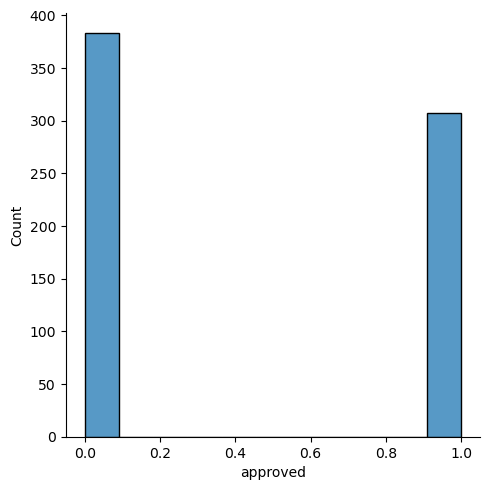

In [416]:
######################################
# Plotting a histogram of our target variable
######################################

sns.displot(df['approved'])

plt.show()

> **Observation:**<br>
> Since there are only 2 classes for our target, this makes sense.


### 3.3.1 Dealing with Outliers <a class="car" id="outlier-detection"></a>
* [Go to Data Prep](#data-prep)

> **Action Items**<br>
> remove outliers for Income. We will be taking log transformation for this variable

In [417]:
df['Income'] = np.log1p(df['Income'])

## 3.4 Categorical data <a class="car" id="categorical-data"></a>
* [Go to Data Prep](#data-prep)

> **categorical variables in use:**<br>
Data is already cleaned and we have isolated the required categorical variables<br><br>




## 3.5 Multivariate Analysis <a class="car" id="mul-analysis"></a>
* [Go to Data Prep](#data-prep)

### Multivariate Analysis outcome:<br><Br>

> Not Required





## 3.5 Feature Transformation <a class="car" id="feature-transform"></a><br>

> **Objective:** <br>
> Not Required


* [Go to Data Prep](#data-prep)

## 3.6 Splitting Data <a class="car" id="data-split"></a><br>
> **Creating a test/train split**<br>
* [Go to Data Prep](#data-prep)

In [418]:
predictors =[ 'debt', 'married', 'bank_customer',
       'emp_industrial', 'emp_materials', 'emp_consumer_services',
       'emp_healthcare', 'emp_financials', 'emp_utilities', 'emp_education',
       'years_employed', 'prior_default',
       'employed', 'credit_score', 'drivers_license', 'citizen_bybirth',
       'citizen_other', 'citizen_temporary', 'Income']

target = ['approved']

X = df[predictors]
y = df[target]
# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.4,random_state=2)

**Note**:<br>
As Stated above, lenders are prohibited by law from using a borrower's ascribed characteristics, such as age, gender, race, ethnicity, or religion, when making credit or loan decisions, I am removing certain characteristic parameters from evaluation.

## 3.7 Data Normalization <a class="car" id="normalization"></a><br>
> **The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information**<br>
> We want to use the summary stats(std dev. and mean) from training data to normalize both training and testing data. 
* [Go to Data Prep](#data-prep)

In [419]:
#We are going to use the Z score to normalize data
cols_to_normalise = ['debt','married','bank_customer','emp_industrial','emp_materials',
                  'emp_consumer_services','emp_healthcare','emp_financials','emp_utilities',
                  'emp_education','years_employed','prior_default','employed','credit_score',
                  'drivers_license','citizen_bybirth','citizen_other','citizen_temporary']
means = X_train[cols_to_normalise].mean()
std = X_train[cols_to_normalise].std()

X_train[cols_to_normalise] = (X_train[cols_to_normalise] - means)/std
X_test[cols_to_normalise] = (X_test[cols_to_normalise] - means)/std



**Decision**: Since we are using log transformation for Income, I won't be normalising it.

# 4. Machine Learning Model Implementation<a class="car" id="ml-model"></a>
> * [KNN Model](#first-model)
> * [Logistic Regression Model](#second-model)


-


<br><br>
* [Go to Top](#table-of-content)

> **KNN Model** <a class="car" id="first-model"></a>
<br>
> Objectives:<br>
> * Run a KNN model for different values of K and select a best model based on accuracy.
> * Compare with LR model for different metrics to finalise a model.

In [420]:
K_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
probab_threshold = 0.5
results = []

for i in K_values:
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.values.ravel())
#     print(knn.predict_proba(X_test))
    y_prediction = (knn.predict_proba(X_test)[:,1]>= probab_threshold ).astype(int)
    
    results.append({'k':i,
                   'recall': metrics.recall_score(y_test,y_prediction),
                   'Accuracy': metrics.accuracy_score(y_test,y_prediction)})
    
output = pd.DataFrame(results)

output

,k,recall,Accuracy
0,1,0.71,0.78
1,3,0.75,0.82
2,5,0.70,0.79
3,7,0.73,0.82
4,9,0.72,0.82
5,11,0.73,0.82
6,13,0.73,0.84
7,15,0.70,0.82
8,17,0.73,0.84
9,19,0.73,0.84


**Decision**: Using K = 9 since we have high accuracy and recall. I'm checking recall because the business model demands it. If there are a large number of false negatives, it means that the bank is losing money on some genuine customers because the model predicts them to be negative.

In [421]:
Model1 = KNeighborsClassifier(n_neighbors=7)
Model1.fit(X_train,y_train.values.ravel())
y_pred_knn = Model1.predict(X_test)
# threshold = [0.2,0.4,0.6]
threshold = np.arange(0,1.1,0.1).tolist()
result = class_perf_measures(Model1,y_test,threshold)
result


,threshold,TP,TN,FP,FN,Precision,Recall,f1,AUC_ROC,Accuracy
0,0.00,135,0,141,0,0.49,1.00,0.66,0.50,0.49
1,0.10,128,58,83,7,0.61,0.95,0.74,0.68,0.67
2,0.20,119,100,41,16,0.74,0.88,0.81,0.80,0.79
3,0.30,109,122,19,26,0.85,0.81,0.83,0.84,0.84
4,0.40,109,122,19,26,0.85,0.81,0.83,0.84,0.84
5,0.50,98,128,13,37,0.88,0.73,0.80,0.82,0.82
6,0.60,87,133,8,48,0.92,0.64,0.76,0.79,0.80
7,0.70,87,133,8,48,0.92,0.64,0.76,0.79,0.80
8,0.80,71,138,3,64,0.96,0.53,0.68,0.75,0.76
9,0.90,44,140,1,91,0.98,0.33,0.49,0.66,0.67


> **LR Model** <a class="car" id="second-model"></a>
<br>
> Objectives:<br>
>  1. Run a LR model and evaluate different performance measures. <br>
>  2. compare various metrics to knn and choose a winning model

In [422]:

lr_model = LogisticRegression()
lr_model.fit(X_train,y_train.values.ravel())

y_train_pred_class_LR = lr_model.predict(X_train)
y_test_pred_class_LR = lr_model.predict(X_test)



**Choose a winning model**

In [423]:
print("Accuracy score for KNN model is ",metrics.accuracy_score(y_test,y_pred_knn).round(2))
print("Recall for KNN model is ",metrics.recall_score(y_test,y_pred_knn).round(2))
print("Accuracy score for LR model is ",metrics.accuracy_score(y_test,y_test_pred_class_LR).round(2))


print("Recall for LR model is ",metrics.recall_score(y_test,y_test_pred_class_LR).round(2))

Accuracy score for KNN model is  0.82
Recall for KNN model is  0.73
Accuracy score for LR model is  0.86
Recall for LR model is  0.81


**Note** : to calculate a winning model, I will also be using AUC score.

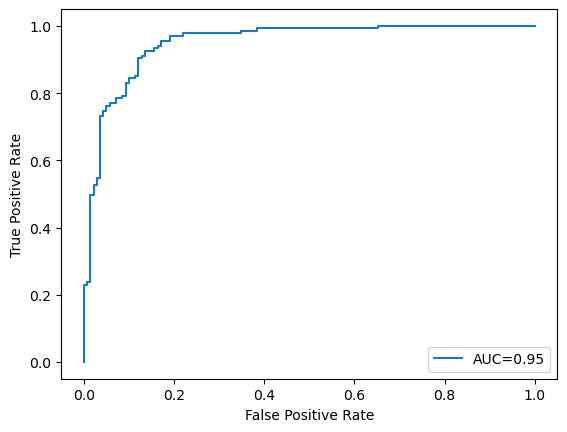

In [424]:
y_pred_Lr = lr_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_Lr)
auc1 = metrics.roc_auc_score(y_test, y_pred_Lr).round(2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc1))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('LR_ROC_p3.png')
plt.show()

plt.close()

KNN ROC curve


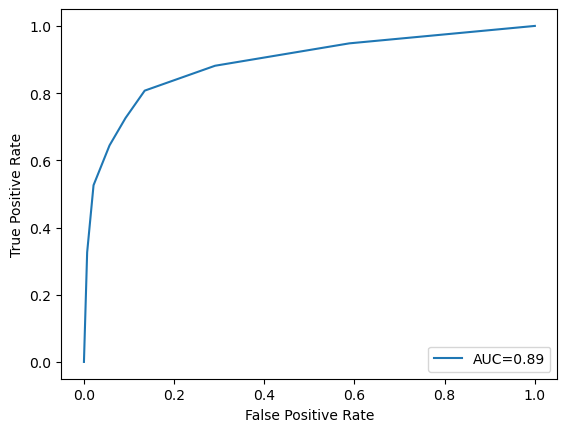

In [425]:
print('KNN ROC curve')
y_pred_proba_KNN = Model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_KNN)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba_KNN).round(2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc2))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('KNN_ROC_p3.png')
plt.show()
plt.close()
# plt.savefig('KNN_ROC.png')

> **Final Model Selection**<br><br>
> For Our final model, it can be indicated that LR has better recall score as well as AUC. Because of our business problem, we have chosen Recall for model selection. False negatives, in my opinion, can have serious consequences, as our bank may lose business.<br> by rejecting loan to suitable candidates.

> LR model has high AUC score. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between loan approval or not.<br><br>
 Therefore, I will be using LR model for further evaluation.<br>
> Some other evaluation measures for classification are:
> * Classification accuracy.
> * Confusion matrix.
> * Precision and recall.
> * F1 score.
> * Sensitivity and specificity.
> * ROC curve and AUC.

In [426]:
class_perf_measures(lr_model,y_test,threshold)


,threshold,TP,TN,FP,FN,Precision,Recall,f1,AUC_ROC,Accuracy
0,0.00,135,0,141,0,0.49,1.00,0.66,0.50,0.49
1,0.10,132,96,45,3,0.75,0.98,0.85,0.83,0.83
2,0.20,130,114,27,5,0.83,0.96,0.89,0.89,0.88
3,0.30,125,119,22,10,0.85,0.93,0.89,0.88,0.88
4,0.40,119,124,17,16,0.88,0.88,0.88,0.88,0.88
5,0.50,110,128,13,25,0.89,0.81,0.85,0.86,0.86
6,0.60,104,131,10,31,0.91,0.77,0.84,0.85,0.85
7,0.70,96,136,5,39,0.95,0.71,0.81,0.84,0.84
8,0.80,75,136,5,60,0.94,0.56,0.70,0.76,0.76
9,0.90,48,139,2,87,0.96,0.36,0.52,0.67,0.68


### Compare Different Thresholds <br>
>  Remember that our objective is to determine if our model that the loan should be approved or not.<br>

> We will be checking for recall(TP/(TP+FP)) to calculate our ideal threshold. I will be discussing the consequences below.<br>

> 1. **Threshold value 0.2** <br>
>   * **False Positives** : Given the low threshold value, many positive predictions can be made, implying that our model will approve the loan for a large number of bank customers. The number of false positives is calculated to be 26. This means that for 26 customers, our model is approving loans that were previously rejected by banks.
>   * **False Negatives** : The probability of a negative outcome must be at least 0.8, which is extremely high. We can see that the negative prediction and false negatives are both very low. If our model rejects a loan for an authentic customer, the bank may suffer losses. Also our stakeholders will loose interest in our model. <br>

>False negatives, in my opinion, can have serious consequences for the business model because a customer who is rejected by our model will take his business to a competitor and the bank will loose money.<br>

> 2. **Threshold value 0.3** <br>
>   * **False Positives**: For this probablity value we are getting high false positives (22) compared to rest of the values.
Still the valuesa are not as high comapred to the total number of records. **Precision** comes out to be 0.85.This is also high accuracy in the entire table.
>   * **False Negatives**: As was previously said, our business model demands that false negative may have large consequences. False negatives value has increased from 6 to 8 slightly impacting recall. This is also a great threshold value for our final model. <br>
>   * This model has the highest accuracy compared to all the thresholds. Also both **Precision and Recall** are fairly good for this value.



> 3. **Threshold value 0.9** <br>
>  * **False Positives**: This threshold value is really high. As a result, our model will typically forecast unfavorable results. As we can see from the table, both True positive and false positive have small values. This means our model will be rejecting a large pool of applicants since we have set the qualified standards very high.
>  * **False Negatives**: Because we are rejecting a large number of applicants, our negative outcomes will be very high. Our false negatives will follow suit. It comes out to 87, resulting in a recall of 0.36, which is too low for our model.
>  * In comparison to previous models, this value cannot be justified to our stakeholders, who will be banks, because they need to expand their customer base and lend more money because the interest earned from this is their primary source of income.


**I will either we using 0.3 which is also the default probablity as threshold value for our model. This has high recall and accuracy. Also this value justifies our business problem**

# 5. Deployment of Model <a class="car" id="model-deployment"></a>

* [Go to Top](#table-of-content)

In [427]:
import pickle
pickle_out = open('classifier1_loan_approver', mode='wb')
pickle.dump([lr_model,knn,means.to_list(),std.to_list()], pickle_out)

pickle_out.close()

In [428]:
%%writefile loan_approver_app.py
import streamlit as st
import pickle
import numpy as np

pickle_in = open('classifier1_loan_approver', 'rb')
pkl_in = pickle.load(pickle_in)

lr_model = pkl_in[0] 
knn = pkl_in[1]
means = pkl_in[2]
std = pkl_in[3]


@st.cache()


# Define the function which will make the prediction using data
# inputs from users
def prediction(input_list, prediction_probability, model_type ='LR'):
    # Make predictions
    if model_type =='LR':
        prediction = (lr_model.predict_proba([input_list])[::,1]>= prediction_probability ).astype(int)
    elif model_type =='KNN':
        prediction = (knn.predict_proba([input_list])[::,1]>= prediction_probability ).astype(int)
    
    if prediction == 0:
        pred = 'Sorry! Your Loan is likely to be rejected'
    else:
        pred = 'Congrats! Your Loan is likely to be approved'
    return pred



def set_citizen_type(citizen_type):
    citizen_bybirth = 0
    citizen_temporary = 0
    citizen_other = 0
    
    if citizen_type =='bybirth':
        citizen_bybirth = 1
    elif citizen_type =='temporary':
        citizen_temporary = 1
    else: citizen_other = 1
    
    return citizen_bybirth,citizen_temporary,citizen_other

def set_employment_type(emptype):
    emp_industrial=0
    emp_materials=0
    emp_consumer_services=0
    emp_healthcare=0
    emp_financials=0
    emp_utilities=0
    emp_education=0
    
    if emptype =='industrial':
        emp_industrial = 1
    elif emptype =='materials':
        emp_materials =1
    elif emptype =='consumer_services':
        emp_consumer_services =1
    elif emptype =='healthcare':
        emp_healthcare =1
    elif emptype =='financials':
        emp_financials =1
    elif emptype =='utilities':
        emp_utilities = 1
    elif emptype =='education':
        emp_education = 1
        
    return emp_industrial,emp_materials,emp_consumer_services,emp_healthcare,emp_financials,emp_utilities,emp_education
        
    

def main():
    
    # Create input fields
    st.markdown("<h1 style='text-align: center; color: red;'>Loan Approval Indicator</h1>", unsafe_allow_html=True)
    
    debt = st.number_input("How much debt you have (in 000's of Dollars)?",
                                  min_value=0.0,
                                  max_value=30.0,
                                  value=20.5,
                                  step=.1,
                                 )
    
    married = st.number_input("Are you married?(0-1)",
                                  min_value=0,
                                  max_value=1,
                                  value=1,
                                  step=1,
                                 )
    
    bank_customer = st.number_input("Are you a bank customer ?(0-1)",
                                  min_value=0,
                                  max_value=1,
                                  value=1,
                                  step=1,
                                 )
    employed = st.number_input("Are you Employed ?(0-1)",
                                  min_value=0,
                                  max_value=1,
                                  value=1,
                                  step=1,
                                 )
    years_employed = Income = st.number_input("How many years of Experience you got? ",
                          min_value=0,
                              max_value=30,
                              value=20,
                              step=10
                         )
    Income = st.number_input("Annual Income(in $) ",
                          min_value=0,
                              max_value=100000,
                              value=50000,
                              step=1000
                         )
    emptype = st.selectbox("Select Employee Type",['industrial','materials','consumer_services','healthcare','financials','utilities','education'])
    emp_industrial,emp_materials,emp_consumer_services,emp_healthcare,emp_financials,emp_utilities,emp_education = set_employment_type(emptype)
    
    prior_default = st.number_input("Do you have any prior Defaults ?(0-1)",
                                  min_value=0,
                                  max_value=1,
                                  value=1,
                                  step=1,
                                 )
    citizen_type = st.selectbox("Select Citizen type",['bybirth','temporary', 'other'])
    citizen_bybirth,citizen_temporary,citizen_other = set_citizen_type(citizen_type)
    
    credit_score = st.number_input("Enter your Credit Score",
                                  min_value=0,
                                  max_value=100,
                                  value=50,
                                  step=10,
                                 )
    
    drivers_license = st.number_input("Do you have a Driver License ?(0-1)",
                                  min_value=0,
                                  max_value=1,
                                  value=1,
                                  step=1,
                                 )
  
    model_type = st.sidebar.selectbox("Model type", ['KNN','LR'])
    prediction_probability = [st.sidebar.slider("Probablity Threshold",0.0, 1.0, 0.3, 0.01)]
    
    #scaling data with test stats used for training
    
    debt_norm = (debt - means[0])/std[0]
    married_norm = (married -means[0])/std[0]
    bank_customer_norm = (bank_customer -means[0])/std[0]
    emp_industrial_norm = (emp_industrial -means[0])/std[0]
    emp_materials_norm = (emp_materials -means[0])/std[0]
    emp_consumer_services_norm = (emp_consumer_services -means[0])/std[0]
    emp_healthcare_norm = (emp_healthcare -means[0])/std[0]
    emp_financials_norm = (emp_financials -means[0])/std[0]
    emp_utilities_norm = (emp_utilities -means[0])/std[0]
    emp_education_norm = (emp_education -means[0])/std[0]
    years_employed_norm = (years_employed -means[0])/std[0]
    prior_default_norm = (prior_default -means[0])/std[0]
    employed_norm = (employed -means[0])/std[0]
    credit_score_norm = (credit_score -means[0])/std[0]
    drivers_license_norm = (drivers_license -means[0])/std[0]
    citizen_bybirth_norm = (citizen_bybirth -means[0])/std[0]
    citizen_other_norm = (citizen_other -means[0])/std[0]
    citizen_temporary_norm = (citizen_temporary -means[0])/std[0]
    Income_norm = np.log1p(Income)
    
    
#     input_data = [debt,married,bank_customer,
#        emp_industrial,emp_materials,emp_consumer_services,
#        emp_healthcare,emp_financials,emp_utilities,emp_education,
#        years_employed,prior_default,
#        employed,credit_score,drivers_license,citizen_bybirth,
#        citizen_other,citizen_temporary]
    
    
#     input_list1 = np.divide(np.subtract(input_data,means),std).tolist()

#     debt_norm = input_list1[0]
#     married_norm =input_list1[1]
#     bank_customer_norm = input_list1[2]
#     emp_industrial_norm = input_list1[3]
#     emp_materials_norm = input_list1[4]
#     emp_consumer_services_norm = input_list1[5]
#     emp_healthcare_norm = input_list1[6]
#     emp_financials_norm = input_list1[7]
#     emp_utilities_norm = input_list1[8]
#     emp_education_norm = input_list1[9]
#     years_employed_norm = input_list1[10]
#     prior_default_norm = input_list1[11]
#     employed_norm = input_list1[12]
#     credit_score_norm = input_list1[13]
#     drivers_license_norm = input_list1[14]
#     citizen_bybirth_norm = input_list1[15]
#     citizen_other_norm = input_list1[16]
#     citizen_temporary_norm = input_list1[17]
#     Income_norm = np.log1p(Income)
    result = ""
#     with st.sidebar:
#         result = prediction(sch_dep_time,carrier_delta,carrier_us,
#        carrier_envoy,carrier_continental,carrier_discovery,
#        carrier_other,dest_jfk,dest_ewr,dest_lga,distance,
#        origin_dca,origin_iad,origin_bwi,bad_weather,Monday,
#        Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday, prediction_probability, model_type)
#         st.success(result)
        

    
    # When 'Predict' is clicked, make the prediction and store it
    if st.button("Predict"):
        result = prediction([debt_norm,married_norm,bank_customer_norm,emp_industrial_norm,
                             emp_materials_norm,emp_consumer_services_norm,emp_healthcare_norm,
                             emp_financials_norm,emp_utilities_norm,emp_education_norm,
                            years_employed_norm,prior_default_norm,employed_norm,credit_score_norm,drivers_license_norm,
                            citizen_bybirth_norm,citizen_other_norm,citizen_temporary_norm,Income_norm], prediction_probability, model_type)
        if result =='Congrats! Your Loan is likely to be approved':
            st.balloons()
        st.success(result)
        
    if st.button('Show ROC curve'):
        if model_type =='KNN':
            st.image('KNN_ROC_p3.png',caption='KNN ROC image')
        elif model_type =='LR':
            st.image('LR_ROC_p3.png',caption='LR ROC image')
       
if __name__=='__main__':
    main()

Writing loan_approver_app.py


In [ ]:
!streamlit run loan_approver_app.py

# Conclusion <a class="car" id="Conclusion"></a>

> We are using a fairly low threshold for our model since our objective is to let in alot of potential customers. This will help us in the competetive market. There will be some defaults but the bank can take separate measures such as collateral and etc to prevent it from loosing money.




* [Go to Top](#table-of-content)